In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import tqdm.notebook as tqdm

from pathlib import Path

%matplotlib inline


import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, GlobalMaxPooling2D

In [2]:
DATA_DIR_PATH = "../data/bengali_AI_handwritten_grapheme_classification"

IMG_HEIGHT = 137
IMG_WIDTH = 236

ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [3]:
original_train_df = pd.read_csv("{}/train.csv".format(DATA_DIR_PATH))
test_df = pd.read_csv("{}/test.csv".format(DATA_DIR_PATH))
class_map_df = pd.read_csv("{}/class_map.csv".format(DATA_DIR_PATH))
sample_submission_df = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR_PATH))

In [4]:
def reshape_img(img_data):
    if isinstance(img_data, pd.Series):
        img_data = img_data.to_numpy()
    
    return img_data.reshape(IMG_HEIGHT, IMG_WIDTH)

In [5]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [77]:
class_map_df

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [6]:
original_train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [7]:
CENTERED_IMAGE_PATH = "../data/bengali_centered"
PREPROCESSED_TRIAN_DATA_CSV_NAME = "new_train_data.csv"

In [8]:
def update_df_with_image_path(df: pd.DataFrame, dataset_name_list: list):
    image_path_list = list()

    for dataset_name in dataset_name_list:
        image_path_data_list = list()
        centered_image_dataset_path = os.path.join(CENTERED_IMAGE_PATH, dataset_name)

        for file in sorted(os.listdir(centered_image_dataset_path)):
            image_id, ext = os.path.splitext(file)

            if ext != ".jpg":
                continue

            idx = int(image_id.split("_")[-1])
            path_data = (idx, image_id, os.path.join(centered_image_dataset_path, file))

            image_path_data_list.append(path_data)

        image_path_data_list = sorted(image_path_data_list, key=lambda path_data: path_data[0])
        image_path_list_in_dataset = list(list(zip(*image_path_data_list))[2])
        image_path_list += image_path_list_in_dataset

    df['preprocessed_image_path'] = image_path_list

In [9]:
# update_df_with_image_path(df=original_train_df, dataset_name_list=["dataset_1", "dataset_2", "dataset_3", "dataset_4"])
# original_train_df.to_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME), mode='w', index=False)

preprocessed_train_df = pd.read_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME))

In [10]:
preprocessed_train_df.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path
200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...
200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...
200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...
200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...
200839,Train_200839,127,2,0,ল্টি,../data/bengali_centered/dataset_4/Train_20083...


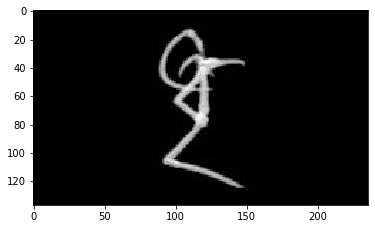

In [11]:
img = cv2.imread(preprocessed_train_df['preprocessed_image_path'][2700])
plt.imshow(img, cmap='gray')
plt.show()

In [72]:
preprocessed_train_df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path
0,Train_0,15,9,5,ক্ট্রো,../data/bengali_centered/dataset_1/Train_0.jpg
1,Train_1,159,0,0,হ,../data/bengali_centered/dataset_1/Train_1.jpg
2,Train_2,22,3,5,খ্রী,../data/bengali_centered/dataset_1/Train_2.jpg
3,Train_3,53,2,2,র্টি,../data/bengali_centered/dataset_1/Train_3.jpg
4,Train_4,71,9,5,থ্রো,../data/bengali_centered/dataset_1/Train_4.jpg
...,...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...
200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...
200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...
200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...


In [12]:
ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [13]:
# from sklearn.model_selection import train_test_split

In [14]:
def get_len_train_test_split(full_len: int, test_ratio: float) -> tuple:
    test_len = int(full_len * test_ratio)
    train_len = full_len - test_len
    return train_len, test_len

In [15]:
def get_len_dataset(dataset) -> int:
    count = 0
    for data in dataset:
        count += 1
    
    return count

In [16]:
path_list = preprocessed_train_df['preprocessed_image_path']

root_list = preprocessed_train_df['grapheme_root']
consonant_list = preprocessed_train_df['consonant_diacritic']
vowel_list = preprocessed_train_df['vowel_diacritic']

batch_size = 256
epochs = 10

In [17]:
len_train, len_test_full = get_len_train_test_split(full_len=len(path_list), test_ratio=0.3)
len_val, len_test = get_len_train_test_split(full_len=len_test_full, test_ratio=0.7)

print(f"Train size : {len_train}, Val size : {len_val}, Test size : {len_test}")

Train size : 140588, Val size : 18076, Test size : 42176


In [76]:
path_list

0            ../data/bengali_centered/dataset_1/Train_0.jpg
1            ../data/bengali_centered/dataset_1/Train_1.jpg
2            ../data/bengali_centered/dataset_1/Train_2.jpg
3            ../data/bengali_centered/dataset_1/Train_3.jpg
4            ../data/bengali_centered/dataset_1/Train_4.jpg
                                ...                        
200835    ../data/bengali_centered/dataset_4/Train_20083...
200836    ../data/bengali_centered/dataset_4/Train_20083...
200837    ../data/bengali_centered/dataset_4/Train_20083...
200838    ../data/bengali_centered/dataset_4/Train_20083...
200839    ../data/bengali_centered/dataset_4/Train_20083...
Name: preprocessed_image_path, Length: 200840, dtype: object

In [18]:
# dataset = tf.data.Dataset.from_tensor_slices({
#     "path_list": path_list,
#     "root_list": root_list,
#     "consonant_list": consonant_list,
#     "vowel_list": vowel_list
# })
dataset = tf.data.Dataset.from_tensor_slices((path_list, root_list, consonant_list, vowel_list))

In [75]:
dataset

<ShuffleDataset shapes: ((), (), (), ()), types: (tf.string, tf.int32, tf.int32, tf.int32)>

In [19]:
train_dataset = dataset.take(len_train)
test_dataset = dataset.skip(len_train)
val_dataset = test_dataset.take(len_val)
test_dataset = test_dataset.skip(len_val)

#print(f"Train size : {get_len_dataset(train_dataset)}, Val size : {get_len_dataset(val_dataset)}, Test size : {get_len_dataset(test_dataset)}")
# Train size : 140588, Val size : 18076, Test size : 42176

In [21]:
import efficientnet.tfkeras as efn

In [22]:
base_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [23]:
base_net.trainable = False

In [78]:
del model

In [90]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='img')

m = base_net(inputs)
m = GlobalMaxPooling2D()(m)


# m = Conv2D(32, 3, padding='same', activation='relu')(inputs)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(64, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(128, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(256, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)


# m = Conv2D(512, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Flatten()(m)
# m = Dropout(rate=0.2)(m)

# m = Dense(256, activation='relu')(m)
# m = Dropout(rate=0.3)(m)
# m = Dense(128, activation='relu')(m)
m = Dropout(rate=0.2)(m)

root = Dense(ROOT_CLASSES_NUM, activation='softmax', name='root')(m)
consonant = Dense(CONSONANT_CLASSES_NUM, activation='softmax', name='consonant')(m)
vowel = Dense(VOWEL_CLASSES_NUM, activation='softmax', name='vowel')(m)

In [91]:
model = tf.keras.Model(inputs=inputs, outputs=[root, consonant, vowel])

In [92]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 137, 236, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b0 (Model)         (None, 5, 8, 1280)   4049564     img[0][0]                        
__________________________________________________________________________________________________
global_max_pooling2d_6 (GlobalM (None, 1280)         0           efficientnet-b0[9][0]            
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 1280)         0           global_max_pooling2d_6[0][0]     
____________________________________________________________________________________________

In [67]:
from tensorflow.keras.utils import plot_model

In [68]:
plot_model(base_net)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [93]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
# ROOT_CLASSES_NUM = 168
# CONSONANT_CLASSES_NUM = 7
# VOWEL_CLASSES_NUM = 11

In [63]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def load_img(path_list):
    return tf.map_fn(read_img, path_list, dtype=tf.float32)

In [94]:
history_list = list()

# img_batch = None  # 이 부분 수정할 것. 비효율적임

# for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(len(path_list)):
# # for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(10240).take(1):
#     if img_batch is None:
#         time_st = time.time()
#         img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
#         time_ed = time.time()
#         print("Elapsed time for loading image data : {}".format(time_ed - time_st))

#     history = model.fit(
#         x={'img': img_batch},
#         y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
#         batch_size=128,  # 256 은 GPU 메모리 부족
#         epochs=2
#     )

#     history_list.append(history)

for epoch in range(50):
    
    print("== Epoch : {} ==\n".format(epoch))
    dataset = dataset.shuffle(len(path_list))
    
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(1280):
#     for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(1024).take(2):
        time_st = time.time()
        img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
        time_ed = time.time()
        print("Elapsed time for loading image data : {}".format(time_ed - time_st))
        
        history = model.fit(
            x={'img': img_batch},
            y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
            batch_size=32  # 64, 128, 256 은 GPU 메모리 부족
        )
        
        # Appending history
        history_list.append((epoch, history))
    
    print(f"Epoch {epoch} - ")

== Epoch : 0 ==

Elapsed time for loading image data : 1.0776844024658203
Train on 1280 samples
1280/1280 [==============================] - 5s 4ms/sample - loss: 132941.9000 - root_loss: 132680.8125 - consonant_loss: 45.0209 - vowel_loss: 216.0530 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0031 - vowel_accuracy: 0.0000e+00
Elapsed time for loading image data : 1.0086781978607178
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132242.8896 - root_loss: 131994.1562 - consonant_loss: 36.8615 - vowel_loss: 211.8588 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0156 - vowel_accuracy: 0.0000e+00
Elapsed time for loading image data : 1.002063512802124
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135386.6645 - root_loss: 135136.7969 - consonant_loss: 36.7923 - vowel_loss: 213.0724 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0227 - vowel_accuracy: 0.0016
Elapsed time for loading image dat

Elapsed time for loading image data : 1.2488081455230713
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131536.8977 - root_loss: 131311.5781 - consonant_loss: 30.3040 - vowel_loss: 195.0371 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0570 - vowel_accuracy: 0.0109
Elapsed time for loading image data : 1.0337483882904053
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 138817.4230 - root_loss: 138590.3281 - consonant_loss: 33.0208 - vowel_loss: 194.0707 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0547 - vowel_accuracy: 0.0039
Elapsed time for loading image data : 0.9702425003051758
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136160.3992 - root_loss: 135946.2500 - consonant_loss: 29.2086 - vowel_loss: 184.9569 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0664 - vowel_accuracy: 0.0117
Elapsed time for loading image data : 1.0549237728118896
T

1280/1280 [==============================] - 2s 1ms/sample - loss: 132262.8039 - root_loss: 132053.4844 - consonant_loss: 32.1931 - vowel_loss: 177.1167 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0570 - vowel_accuracy: 0.0109
Elapsed time for loading image data : 1.000772476196289
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134540.2100 - root_loss: 134328.2812 - consonant_loss: 29.1992 - vowel_loss: 182.7073 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0789 - vowel_accuracy: 0.0078
Elapsed time for loading image data : 0.9736542701721191
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131826.7502 - root_loss: 131602.9688 - consonant_loss: 33.1903 - vowel_loss: 190.5800 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0703 - vowel_accuracy: 0.0117
Elapsed time for loading image data : 0.9709296226501465
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 136249.0123 - root_loss: 136034.7188 - consonant_loss: 28.8514 - vowel_loss: 185.4528 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0859 - vowel_accuracy: 0.0148
Elapsed time for loading image data : 1.1282050609588623
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133743.8834 - root_loss: 133533.1406 - consonant_loss: 31.3735 - vowel_loss: 179.3666 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0734 - vowel_accuracy: 0.0141
Elapsed time for loading image data : 1.1395435333251953
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135251.8225 - root_loss: 135039.6250 - consonant_loss: 28.4111 - vowel_loss: 183.7943 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0836 - vowel_accuracy: 0.0141
Elapsed time for loading image data : 1.0502665042877197
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 132762.9129 - root_loss: 132554.0625 - consonant_loss: 30.9338 - vowel_loss: 177.9360 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0844 - vowel_accuracy: 0.0219
Elapsed time for loading image data : 1.0292165279388428
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131043.6539 - root_loss: 130832.9219 - consonant_loss: 30.3861 - vowel_loss: 180.3335 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0812 - vowel_accuracy: 0.0219
Elapsed time for loading image data : 1.0575096607208252
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135535.7131 - root_loss: 135323.6094 - consonant_loss: 29.2235 - vowel_loss: 182.8897 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0938 - vowel_accuracy: 0.0141
Elapsed time for loading image data : 0.9625768661499023
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129296.5502 - root_loss: 129090.0000 - consonant_loss: 30.3658 - vowel_loss: 176.1961 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0867 - vowel_accuracy: 0.0258
Elapsed time for loading image data : 1.0324461460113525
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134115.0715 - root_loss: 133910.4219 - consonant_loss: 30.0811 - vowel_loss: 174.5729 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0961 - vowel_accuracy: 0.0227
Elapsed time for loading image data : 1.0258820056915283
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131042.9844 - root_loss: 130842.8906 - consonant_loss: 29.3718 - vowel_loss: 170.7173 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0977 - vowel_accuracy: 0.0211
Elapsed time for loading image data : 1.0211646556854248
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 133379.1797 - root_loss: 133179.5781 - consonant_loss: 26.9250 - vowel_loss: 172.6510 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1000 - vowel_accuracy: 0.0180
Elapsed time for loading image data : 0.9924471378326416
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130531.8576 - root_loss: 130328.0156 - consonant_loss: 30.0373 - vowel_loss: 173.8050 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0992 - vowel_accuracy: 0.0289
Elapsed time for loading image data : 1.0276005268096924
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134605.6389 - root_loss: 134398.1094 - consonant_loss: 28.2278 - vowel_loss: 179.2865 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1016 - vowel_accuracy: 0.0219
Elapsed time for loading image data : 1.1231582164764404
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 2ms/sample - loss: 131463.3510 - root_loss: 131258.4375 - consonant_loss: 28.4452 - vowel_loss: 176.4851 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1102 - vowel_accuracy: 0.0289
Elapsed time for loading image data : 1.0797460079193115
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132654.9467 - root_loss: 132453.5000 - consonant_loss: 28.2179 - vowel_loss: 173.2169 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1039 - vowel_accuracy: 0.0227
Elapsed time for loading image data : 1.0248394012451172
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134816.9104 - root_loss: 134618.8438 - consonant_loss: 27.9703 - vowel_loss: 170.1027 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1109 - vowel_accuracy: 0.0328
Elapsed time for loading image data : 0.9914522171020508
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 132069.7248 - root_loss: 131866.3750 - consonant_loss: 29.7625 - vowel_loss: 173.5793 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1023 - vowel_accuracy: 0.0312
Elapsed time for loading image data : 0.9807648658752441
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134989.2488 - root_loss: 134790.8438 - consonant_loss: 29.6455 - vowel_loss: 168.7597 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1086 - vowel_accuracy: 0.0312
Elapsed time for loading image data : 0.9832663536071777
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125863.3494 - root_loss: 125668.4844 - consonant_loss: 28.9585 - vowel_loss: 165.9012 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1102 - vowel_accuracy: 0.0266
Elapsed time for loading image data : 0.9921665191650391
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 131454.3516 - root_loss: 131253.9062 - consonant_loss: 28.9184 - vowel_loss: 171.5251 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1125 - vowel_accuracy: 0.0352
Elapsed time for loading image data : 1.022162914276123
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130891.5641 - root_loss: 130695.7891 - consonant_loss: 28.5328 - vowel_loss: 167.2377 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.0977 - vowel_accuracy: 0.0391
Elapsed time for loading image data : 1.039480447769165
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131670.6799 - root_loss: 131473.3750 - consonant_loss: 26.0640 - vowel_loss: 171.2475 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1094 - vowel_accuracy: 0.0375
Elapsed time for loading image data : 1.0174543857574463
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 129848.3826 - root_loss: 129651.8359 - consonant_loss: 26.8706 - vowel_loss: 169.6706 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1078 - vowel_accuracy: 0.0352
Elapsed time for loading image data : 1.0249476432800293
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133150.6314 - root_loss: 132954.5312 - consonant_loss: 27.1512 - vowel_loss: 168.9729 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1266 - vowel_accuracy: 0.0375
Elapsed time for loading image data : 1.0055701732635498
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131341.8414 - root_loss: 131143.9062 - consonant_loss: 27.9715 - vowel_loss: 169.9730 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1094 - vowel_accuracy: 0.0375
Elapsed time for loading image data : 1.075092077255249
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 132680.2590 - root_loss: 132491.0625 - consonant_loss: 27.3595 - vowel_loss: 161.8617 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1187 - vowel_accuracy: 0.0336
Elapsed time for loading image data : 1.0600330829620361
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132739.8025 - root_loss: 132547.6875 - consonant_loss: 26.4999 - vowel_loss: 165.6226 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1148 - vowel_accuracy: 0.0398
Elapsed time for loading image data : 1.0685482025146484
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130301.2867 - root_loss: 130107.7500 - consonant_loss: 26.0847 - vowel_loss: 167.4295 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1227 - vowel_accuracy: 0.0406
Elapsed time for loading image data : 1.0078155994415283
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 134583.4473 - root_loss: 134390.2969 - consonant_loss: 26.8144 - vowel_loss: 166.3322 - root_accuracy: 0.0016 - consonant_accuracy: 0.1195 - vowel_accuracy: 0.0437
Elapsed time for loading image data : 0.9593765735626221
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134807.9529 - root_loss: 134619.4375 - consonant_loss: 26.0059 - vowel_loss: 162.5017 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1047 - vowel_accuracy: 0.0414
Elapsed time for loading image data : 0.9533510208129883
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132649.0344 - root_loss: 132460.0469 - consonant_loss: 27.6666 - vowel_loss: 161.3223 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1281 - vowel_accuracy: 0.0484
Elapsed time for loading image data : 0.9934177398681641
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - l

1280/1280 [==============================] - 2s 1ms/sample - loss: 130590.5209 - root_loss: 130398.5234 - consonant_loss: 25.5477 - vowel_loss: 166.4186 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0469
Elapsed time for loading image data : 0.9667360782623291
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133553.9713 - root_loss: 133354.0625 - consonant_loss: 26.4664 - vowel_loss: 173.4550 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1172 - vowel_accuracy: 0.0422
Elapsed time for loading image data : 0.9936637878417969
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131135.3279 - root_loss: 130944.0859 - consonant_loss: 26.6416 - vowel_loss: 164.5786 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0422
Elapsed time for loading image data : 0.965442419052124
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 130077.4918 - root_loss: 129884.3984 - consonant_loss: 27.3377 - vowel_loss: 165.7438 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1250 - vowel_accuracy: 0.0422
Elapsed time for loading image data : 1.014800786972046
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131871.8965 - root_loss: 131686.9375 - consonant_loss: 25.8615 - vowel_loss: 159.0747 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0437
Elapsed time for loading image data : 1.014211654663086
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132960.4109 - root_loss: 132776.6094 - consonant_loss: 26.6056 - vowel_loss: 157.1764 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1227 - vowel_accuracy: 0.0508
Elapsed time for loading image data : 0.9990248680114746
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 130072.3594 - root_loss: 129883.8516 - consonant_loss: 25.5429 - vowel_loss: 162.9958 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1297 - vowel_accuracy: 0.0578
Elapsed time for loading image data : 0.9799859523773193
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132391.0713 - root_loss: 132206.8750 - consonant_loss: 24.6843 - vowel_loss: 159.4892 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1211 - vowel_accuracy: 0.0492
Elapsed time for loading image data : 0.9999666213989258
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133280.4398 - root_loss: 133085.8281 - consonant_loss: 25.7503 - vowel_loss: 168.8682 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1211 - vowel_accuracy: 0.0484
Elapsed time for loading image data : 1.0164713859558105
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 132212.0973 - root_loss: 132021.0312 - consonant_loss: 25.9519 - vowel_loss: 165.1047 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1219 - vowel_accuracy: 0.0602
Elapsed time for loading image data : 0.9855906963348389
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133148.9648 - root_loss: 132950.9062 - consonant_loss: 25.9640 - vowel_loss: 172.0757 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1258 - vowel_accuracy: 0.0484
Elapsed time for loading image data : 0.9621140956878662
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136360.1199 - root_loss: 136172.7656 - consonant_loss: 24.8600 - vowel_loss: 162.5108 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0555
Elapsed time for loading image data : 1.006253957748413
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 133961.8223 - root_loss: 133772.5000 - consonant_loss: 26.0242 - vowel_loss: 163.2893 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0547
Elapsed time for loading image data : 1.0016140937805176
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131469.7283 - root_loss: 131283.6406 - consonant_loss: 24.4172 - vowel_loss: 161.6962 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0516
Elapsed time for loading image data : 1.3336527347564697
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129094.9973 - root_loss: 128906.6250 - consonant_loss: 24.2024 - vowel_loss: 164.1473 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1227 - vowel_accuracy: 0.0586
Elapsed time for loading image data : 0.9774723052978516
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 134724.2924 - root_loss: 134544.7188 - consonant_loss: 22.9395 - vowel_loss: 156.6393 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1281 - vowel_accuracy: 0.0555
Elapsed time for loading image data : 0.9995741844177246
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134852.9033 - root_loss: 134668.4688 - consonant_loss: 24.9590 - vowel_loss: 159.5060 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1266 - vowel_accuracy: 0.0578
Elapsed time for loading image data : 0.9776504039764404
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133433.4080 - root_loss: 133246.8281 - consonant_loss: 25.5500 - vowel_loss: 161.0241 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0570
Elapsed time for loading image data : 0.9882876873016357
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 130615.5236 - root_loss: 130424.9766 - consonant_loss: 26.6633 - vowel_loss: 163.8733 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1281 - vowel_accuracy: 0.0523
Elapsed time for loading image data : 1.0061516761779785
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136955.2451 - root_loss: 136765.8438 - consonant_loss: 24.0727 - vowel_loss: 165.3417 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1203 - vowel_accuracy: 0.0516
Elapsed time for loading image data : 0.9714839458465576
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133477.9158 - root_loss: 133284.4219 - consonant_loss: 25.3606 - vowel_loss: 168.1176 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0469
Elapsed time for loading image data : 0.9428451061248779
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 133194.5689 - root_loss: 133010.1562 - consonant_loss: 22.9254 - vowel_loss: 161.4984 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9559435844421387
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134152.4074 - root_loss: 133963.4375 - consonant_loss: 27.6021 - vowel_loss: 161.3448 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0602
Elapsed time for loading image data : 1.014024019241333
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128614.5916 - root_loss: 128422.6641 - consonant_loss: 24.6051 - vowel_loss: 167.3215 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1328 - vowel_accuracy: 0.0555
Elapsed time for loading image data : 0.9874448776245117
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 132716.4441 - root_loss: 132532.4375 - consonant_loss: 23.4540 - vowel_loss: 160.5455 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0531
Elapsed time for loading image data : 0.9855556488037109
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132185.2084 - root_loss: 132004.6094 - consonant_loss: 24.5144 - vowel_loss: 156.0674 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0617
Elapsed time for loading image data : 1.0404951572418213
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 136038.7779 - root_loss: 135854.6719 - consonant_loss: 21.9116 - vowel_loss: 162.1797 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 0.8683099746704102
Train on 1068 samples
1068/1068 [==============================] - 1s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129706.0754 - root_loss: 129530.0469 - consonant_loss: 23.7154 - vowel_loss: 152.2957 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 0.953866720199585
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131257.6334 - root_loss: 131076.7812 - consonant_loss: 25.4089 - vowel_loss: 155.4301 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0570
Elapsed time for loading image data : 0.9891314506530762
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127937.0232 - root_loss: 127762.1406 - consonant_loss: 23.2064 - vowel_loss: 151.6789 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 0.9545776844024658
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 132862.9098 - root_loss: 132679.0938 - consonant_loss: 23.3605 - vowel_loss: 160.4613 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9743509292602539
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 134532.6316 - root_loss: 134348.9844 - consonant_loss: 25.8675 - vowel_loss: 157.7944 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 1.001948595046997
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132209.4006 - root_loss: 132031.0312 - consonant_loss: 24.2046 - vowel_loss: 154.1888 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9739425182342529
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 133726.3719 - root_loss: 133546.1719 - consonant_loss: 22.7829 - vowel_loss: 157.3892 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9645955562591553
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131403.0906 - root_loss: 131220.5312 - consonant_loss: 23.1548 - vowel_loss: 159.4162 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0516
Elapsed time for loading image data : 0.9793014526367188
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132343.1312 - root_loss: 132157.2812 - consonant_loss: 22.9951 - vowel_loss: 162.8408 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9571330547332764
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 125304.2332 - root_loss: 125129.5000 - consonant_loss: 24.1611 - vowel_loss: 150.5775 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 1.0527257919311523
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127587.9908 - root_loss: 127403.9844 - consonant_loss: 22.2380 - vowel_loss: 161.7660 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9924771785736084
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131347.2064 - root_loss: 131161.1719 - consonant_loss: 23.8383 - vowel_loss: 162.1860 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0648
Elapsed time for loading image data : 0.9915885925292969
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129375.3281 - root_loss: 129195.4219 - consonant_loss: 22.4878 - vowel_loss: 157.4183 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0594
Elapsed time for loading image data : 0.9971356391906738
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131291.0053 - root_loss: 131111.4844 - consonant_loss: 22.5308 - vowel_loss: 156.9863 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 1.0308208465576172
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132134.4998 - root_loss: 131955.5312 - consonant_loss: 22.4693 - vowel_loss: 156.4774 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9976270198822021
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 130122.9250 - root_loss: 129943.2500 - consonant_loss: 23.9869 - vowel_loss: 155.6945 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0547
Elapsed time for loading image data : 0.9883036613464355
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132859.1395 - root_loss: 132676.5781 - consonant_loss: 23.3603 - vowel_loss: 159.2101 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9848189353942871
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127921.5865 - root_loss: 127739.7031 - consonant_loss: 24.3162 - vowel_loss: 157.5576 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9910192489624023
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 128857.2686 - root_loss: 128681.8125 - consonant_loss: 22.2489 - vowel_loss: 153.2069 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 1.1188428401947021
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129979.0072 - root_loss: 129805.3594 - consonant_loss: 22.2952 - vowel_loss: 151.3568 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 1.443028450012207
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130948.5898 - root_loss: 130775.7891 - consonant_loss: 24.3862 - vowel_loss: 148.4007 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1328 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 1.1377179622650146
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 131551.2432 - root_loss: 131380.0938 - consonant_loss: 23.8202 - vowel_loss: 147.3249 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1258 - vowel_accuracy: 0.0703
Elapsed time for loading image data : 1.0070371627807617
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130134.3947 - root_loss: 129961.5859 - consonant_loss: 22.8137 - vowel_loss: 149.9934 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0633
Elapsed time for loading image data : 0.9673585891723633
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133243.1824 - root_loss: 133064.1250 - consonant_loss: 23.8700 - vowel_loss: 155.1823 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9572720527648926
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 130031.3904 - root_loss: 129856.9609 - consonant_loss: 23.0162 - vowel_loss: 151.4016 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0734
Elapsed time for loading image data : 0.9970986843109131
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130166.8572 - root_loss: 129983.3594 - consonant_loss: 20.0394 - vowel_loss: 163.4670 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9792201519012451
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132220.5133 - root_loss: 132042.4219 - consonant_loss: 21.7518 - vowel_loss: 156.3230 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0656
Elapsed time for loading image data : 1.0027179718017578
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 130222.6252 - root_loss: 130048.3359 - consonant_loss: 22.5774 - vowel_loss: 151.7073 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1297 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 1.0145642757415771
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130924.1111 - root_loss: 130754.4219 - consonant_loss: 23.2957 - vowel_loss: 146.3800 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9889917373657227
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133664.8779 - root_loss: 133489.2812 - consonant_loss: 22.7637 - vowel_loss: 152.8427 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 1.0397753715515137
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 131037.1662 - root_loss: 130864.8594 - consonant_loss: 21.6341 - vowel_loss: 150.6853 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9596776962280273
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132846.9447 - root_loss: 132668.3594 - consonant_loss: 22.0146 - vowel_loss: 156.5536 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9516324996948242
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133561.2383 - root_loss: 133383.0938 - consonant_loss: 23.6116 - vowel_loss: 154.5156 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1258 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 1.0084331035614014
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 131281.2027 - root_loss: 131098.1250 - consonant_loss: 23.1847 - vowel_loss: 159.8941 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 0.9431490898132324
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133633.2877 - root_loss: 133458.8906 - consonant_loss: 21.3444 - vowel_loss: 153.0599 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9794979095458984
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128880.2785 - root_loss: 128700.2500 - consonant_loss: 22.5606 - vowel_loss: 157.4599 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9985966682434082
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129486.5277 - root_loss: 129312.9766 - consonant_loss: 21.5939 - vowel_loss: 151.9648 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 0.9633944034576416
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127160.7631 - root_loss: 126985.2734 - consonant_loss: 21.4150 - vowel_loss: 154.0674 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0914
Elapsed time for loading image data : 0.9961488246917725
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129979.7977 - root_loss: 129804.5000 - consonant_loss: 22.1854 - vowel_loss: 153.1098 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 1.0046532154083252
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 133888.6795 - root_loss: 133715.1719 - consonant_loss: 21.8978 - vowel_loss: 151.5916 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9466867446899414
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131558.2678 - root_loss: 131387.4688 - consonant_loss: 22.2367 - vowel_loss: 148.5495 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 1.018294095993042
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127511.2914 - root_loss: 127336.3359 - consonant_loss: 21.5085 - vowel_loss: 153.4402 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9896864891052246
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 135599.6807 - root_loss: 135425.9688 - consonant_loss: 20.6679 - vowel_loss: 153.0312 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9814727306365967
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132109.3727 - root_loss: 131932.4844 - consonant_loss: 22.4805 - vowel_loss: 154.4295 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0570
Elapsed time for loading image data : 0.9940605163574219
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131581.2836 - root_loss: 131406.3281 - consonant_loss: 23.3542 - vowel_loss: 151.6074 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9680733680725098
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 133264.9992 - root_loss: 133090.2188 - consonant_loss: 24.2110 - vowel_loss: 150.5699 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 1.4085781574249268
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127458.9465 - root_loss: 127278.5625 - consonant_loss: 22.0601 - vowel_loss: 158.3222 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1242 - vowel_accuracy: 0.0797
Elapsed time for loading image data : 1.004687786102295
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129668.6990 - root_loss: 129490.7500 - consonant_loss: 23.4143 - vowel_loss: 154.5364 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0680
Elapsed time for loading image data : 0.9634530544281006
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 129871.9350 - root_loss: 129701.3281 - consonant_loss: 22.0086 - vowel_loss: 148.6027 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 1.0116090774536133
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 135176.8752 - root_loss: 135003.7188 - consonant_loss: 19.7093 - vowel_loss: 153.4330 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.847686767578125
Train on 1068 samples
1068/1068 [==============================] - 1s 1ms/sample - loss: 126350.8876 - root_loss: 126080.9688 - consonant_loss: 21.1329 - vowel_loss: 142.4170 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1404 - vowel_accuracy: 0.0852
Epoch 8 - 
== Epoch : 9 ==

Elapsed time for loading image data : 0.9524803161621094
Train on 1280 samples
1280/1280 [====================

1280/1280 [==============================] - 2s 1ms/sample - loss: 129493.3314 - root_loss: 129323.2109 - consonant_loss: 22.7237 - vowel_loss: 147.3756 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9510607719421387
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127513.8357 - root_loss: 127348.4766 - consonant_loss: 20.7707 - vowel_loss: 144.6192 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1250 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9865632057189941
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130101.5883 - root_loss: 129933.1250 - consonant_loss: 22.3660 - vowel_loss: 146.1116 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0781
Elapsed time for loading image data : 0.9983525276184082
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 133080.6613 - root_loss: 132906.6250 - consonant_loss: 23.3607 - vowel_loss: 150.6959 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 0.9719200134277344
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129802.1469 - root_loss: 129636.5859 - consonant_loss: 21.2913 - vowel_loss: 144.2672 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 1.0452125072479248
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128854.1461 - root_loss: 128678.9766 - consonant_loss: 21.0502 - vowel_loss: 154.1223 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 1.004591464996338
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 130074.2166 - root_loss: 129905.6484 - consonant_loss: 20.6451 - vowel_loss: 147.9216 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9895236492156982
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130998.8684 - root_loss: 130825.6250 - consonant_loss: 20.4772 - vowel_loss: 152.7615 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 1.0580224990844727
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131126.8736 - root_loss: 130951.3125 - consonant_loss: 22.2744 - vowel_loss: 153.2763 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 1.0018062591552734
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126901.2480 - root_loss: 126726.7734 - consonant_loss: 20.0600 - vowel_loss: 154.4026 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1305 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 0.9703633785247803
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129802.2375 - root_loss: 129628.1406 - consonant_loss: 21.5719 - vowel_loss: 152.5169 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.9933714866638184
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130157.3525 - root_loss: 129984.4531 - consonant_loss: 21.9429 - vowel_loss: 150.9812 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1273 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9476351737976074
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129836.3672 - root_loss: 129669.4844 - consonant_loss: 20.5125 - vowel_loss: 146.3533 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0969
Elapsed time for loading image data : 0.9844412803649902
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129806.5391 - root_loss: 129637.1719 - consonant_loss: 20.5364 - vowel_loss: 148.8302 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0805
Elapsed time for loading image data : 0.9662606716156006
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129696.7783 - root_loss: 129527.2266 - consonant_loss: 22.5459 - vowel_loss: 146.9980 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9325549602508545
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 131343.9463 - root_loss: 131173.0938 - consonant_loss: 21.1703 - vowel_loss: 149.6859 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.9989430904388428
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126410.4549 - root_loss: 126237.1250 - consonant_loss: 22.2620 - vowel_loss: 151.0507 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.1000
Elapsed time for loading image data : 1.005075454711914
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126224.1961 - root_loss: 126058.5859 - consonant_loss: 21.9417 - vowel_loss: 143.6893 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 0.9627077579498291
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 129461.3830 - root_loss: 129293.2734 - consonant_loss: 20.7371 - vowel_loss: 147.4106 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.9586484432220459
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129363.4314 - root_loss: 129201.0234 - consonant_loss: 21.8758 - vowel_loss: 140.5534 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 1.0039854049682617
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132647.5938 - root_loss: 132479.2969 - consonant_loss: 22.0199 - vowel_loss: 146.2763 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 1.006251573562622
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 128994.6287 - root_loss: 128830.8359 - consonant_loss: 20.9362 - vowel_loss: 142.8601 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9547810554504395
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133464.6961 - root_loss: 133294.9062 - consonant_loss: 21.5552 - vowel_loss: 148.2135 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1297 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9892392158508301
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132306.4330 - root_loss: 132133.7031 - consonant_loss: 21.0766 - vowel_loss: 151.6731 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.967139720916748
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 129915.3146 - root_loss: 129741.9531 - consonant_loss: 18.3412 - vowel_loss: 155.0055 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 1.0066440105438232
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131113.2920 - root_loss: 130945.4766 - consonant_loss: 20.2813 - vowel_loss: 147.5343 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9637272357940674
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130524.6730 - root_loss: 130356.5156 - consonant_loss: 20.7904 - vowel_loss: 147.3638 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9411139488220215
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 131312.9807 - root_loss: 131144.8906 - consonant_loss: 20.8115 - vowel_loss: 147.2587 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.97037672996521
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128903.7854 - root_loss: 128733.0781 - consonant_loss: 21.2535 - vowel_loss: 149.4331 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9943408966064453
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133709.5861 - root_loss: 133545.3125 - consonant_loss: 22.6061 - vowel_loss: 141.6614 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 1.0240907669067383
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 132327.7703 - root_loss: 132158.8750 - consonant_loss: 21.3424 - vowel_loss: 147.5695 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 1.0093255043029785
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128160.1320 - root_loss: 127987.3906 - consonant_loss: 21.7857 - vowel_loss: 150.9415 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1312 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 1.0059516429901123
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127523.5178 - root_loss: 127352.9219 - consonant_loss: 22.2413 - vowel_loss: 148.3428 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.9333639144897461
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 128224.4240 - root_loss: 128053.1875 - consonant_loss: 20.5997 - vowel_loss: 150.5984 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0758
Elapsed time for loading image data : 0.9868669509887695
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128983.2408 - root_loss: 128815.0234 - consonant_loss: 19.4349 - vowel_loss: 148.7706 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0938
Elapsed time for loading image data : 0.9910249710083008
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126501.4025 - root_loss: 126342.0234 - consonant_loss: 20.6848 - vowel_loss: 138.7076 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0914
Elapsed time for loading image data : 0.935457706451416
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 128476.3805 - root_loss: 128307.8281 - consonant_loss: 20.4111 - vowel_loss: 148.1354 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0961
Elapsed time for loading image data : 0.9857213497161865
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130349.7785 - root_loss: 130179.1406 - consonant_loss: 19.6298 - vowel_loss: 151.0168 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0945
Elapsed time for loading image data : 1.0002048015594482
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128283.0092 - root_loss: 128121.1250 - consonant_loss: 18.9135 - vowel_loss: 142.9820 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0914
Elapsed time for loading image data : 0.9746749401092529
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126069.0883 - root_loss: 125901.3984 - consonant_loss: 19.9873 - vowel_loss: 147.6861 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9762978553771973
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128812.2082 - root_loss: 128650.9219 - consonant_loss: 19.3784 - vowel_loss: 141.9082 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9577696323394775
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128318.9242 - root_loss: 128149.5469 - consonant_loss: 20.5972 - vowel_loss: 148.7767 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.9868931770324707
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129894.4855 - root_loss: 129727.2969 - consonant_loss: 21.2506 - vowel_loss: 145.9149 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.9238767623901367
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127165.2105 - root_loss: 126996.8125 - consonant_loss: 20.5972 - vowel_loss: 147.7922 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.952094554901123
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126955.6469 - root_loss: 126788.0156 - consonant_loss: 19.7014 - vowel_loss: 147.9249 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 1.0068519115447998
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 129311.3740 - root_loss: 129141.5781 - consonant_loss: 21.8850 - vowel_loss: 147.9204 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1289 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.984163761138916
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126794.3338 - root_loss: 126629.1484 - consonant_loss: 19.7371 - vowel_loss: 145.4657 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 1.0116162300109863
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 132345.4861 - root_loss: 132179.1250 - consonant_loss: 19.6606 - vowel_loss: 146.6867 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9218776226043701
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1068/1068 [==============================] - 1s 1ms/sample - loss: 125079.5593 - root_loss: 125202.9141 - consonant_loss: 19.3799 - vowel_loss: 137.0564 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0833
Epoch 12 - 
== Epoch : 13 ==

Elapsed time for loading image data : 0.9517428874969482
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128848.9326 - root_loss: 128684.4844 - consonant_loss: 21.8865 - vowel_loss: 142.5633 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9199848175048828
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127528.9514 - root_loss: 127364.8516 - consonant_loss: 20.1195 - vowel_loss: 143.9737 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.945183515548706
Train on 1280 samples
1280/1280 [==================

1280/1280 [==============================] - 2s 1ms/sample - loss: 129834.5018 - root_loss: 129671.1250 - consonant_loss: 20.5964 - vowel_loss: 142.7986 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 1.013596534729004
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128083.0410 - root_loss: 127914.1406 - consonant_loss: 19.0412 - vowel_loss: 149.8680 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 1.004181146621704
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133586.3408 - root_loss: 133415.2188 - consonant_loss: 20.0929 - vowel_loss: 151.0287 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 1.0369527339935303
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 127068.6844 - root_loss: 126902.3594 - consonant_loss: 19.5879 - vowel_loss: 146.7438 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.0711
Elapsed time for loading image data : 0.9560351371765137
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127762.1420 - root_loss: 127601.2031 - consonant_loss: 20.8543 - vowel_loss: 140.1031 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1297 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.999457836151123
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130608.4986 - root_loss: 130446.8750 - consonant_loss: 18.5749 - vowel_loss: 143.0566 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.1016
Elapsed time for loading image data : 0.9972102642059326
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 131361.7473 - root_loss: 131191.6250 - consonant_loss: 20.7912 - vowel_loss: 149.3506 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0945
Elapsed time for loading image data : 0.9552817344665527
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131012.8441 - root_loss: 130847.5000 - consonant_loss: 18.4334 - vowel_loss: 146.9034 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9352965354919434
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129746.9287 - root_loss: 129581.7500 - consonant_loss: 20.3539 - vowel_loss: 144.8248 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.9694297313690186
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129526.2887 - root_loss: 129361.4766 - consonant_loss: 20.3894 - vowel_loss: 144.4107 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 0.9677836894989014
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128310.4154 - root_loss: 128143.8281 - consonant_loss: 19.9104 - vowel_loss: 146.6917 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9612128734588623
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126568.5348 - root_loss: 126402.6406 - consonant_loss: 19.9380 - vowel_loss: 145.9555 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0977
Elapsed time for loading image data : 1.33860445022583
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 128698.6951 - root_loss: 128535.0469 - consonant_loss: 20.9516 - vowel_loss: 142.6863 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1617 - vowel_accuracy: 0.0953
Elapsed time for loading image data : 0.963986873626709
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125969.7969 - root_loss: 125804.4219 - consonant_loss: 20.2333 - vowel_loss: 145.0990 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 1.0295839309692383
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129135.4145 - root_loss: 128974.4141 - consonant_loss: 19.5772 - vowel_loss: 141.4069 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1273 - vowel_accuracy: 0.0828
Elapsed time for loading image data : 0.9716756343841553
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 125432.4344 - root_loss: 125271.1875 - consonant_loss: 20.6398 - vowel_loss: 140.6184 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1562 - vowel_accuracy: 0.0961
Elapsed time for loading image data : 1.0426547527313232
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128851.4447 - root_loss: 128689.5859 - consonant_loss: 17.9255 - vowel_loss: 143.9312 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 0.9680993556976318
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125809.5154 - root_loss: 125645.0391 - consonant_loss: 20.8357 - vowel_loss: 143.6431 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9986531734466553
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 131585.0740 - root_loss: 131422.8281 - consonant_loss: 20.8477 - vowel_loss: 141.4097 - root_accuracy: 0.0016 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 0.9817466735839844
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127775.8047 - root_loss: 127609.9609 - consonant_loss: 19.1594 - vowel_loss: 146.6842 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9991099834442139
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129065.9400 - root_loss: 128903.5000 - consonant_loss: 18.9970 - vowel_loss: 143.4397 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0961
Elapsed time for loading image data : 1.0176093578338623
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - l

1280/1280 [==============================] - 2s 1ms/sample - loss: 130684.1309 - root_loss: 130516.1641 - consonant_loss: 19.6285 - vowel_loss: 148.3485 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.1000
Elapsed time for loading image data : 1.005687952041626
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128491.2684 - root_loss: 128326.4531 - consonant_loss: 20.6807 - vowel_loss: 144.1163 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1219 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 1.0148591995239258
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130634.8812 - root_loss: 130472.7656 - consonant_loss: 20.3207 - vowel_loss: 141.7961 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.1016
Elapsed time for loading image data : 1.0297701358795166
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 129052.3619 - root_loss: 128889.4609 - consonant_loss: 19.4998 - vowel_loss: 143.3832 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9889485836029053
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127206.9018 - root_loss: 127039.7031 - consonant_loss: 19.9418 - vowel_loss: 147.2741 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0977
Elapsed time for loading image data : 0.9708890914916992
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126703.6125 - root_loss: 126543.2734 - consonant_loss: 19.9298 - vowel_loss: 140.4141 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0773
Elapsed time for loading image data : 0.9939548969268799
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 132132.6512 - root_loss: 131972.5625 - consonant_loss: 21.4043 - vowel_loss: 138.6647 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9861927032470703
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125331.1150 - root_loss: 125168.1641 - consonant_loss: 19.0330 - vowel_loss: 143.9360 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0984
Elapsed time for loading image data : 0.9478704929351807
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129139.8184 - root_loss: 128976.2656 - consonant_loss: 19.2353 - vowel_loss: 144.3153 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0953
Elapsed time for loading image data : 0.977515459060669
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 126352.0146 - root_loss: 126187.5156 - consonant_loss: 20.9029 - vowel_loss: 143.6077 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9579868316650391
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129709.3381 - root_loss: 129551.0000 - consonant_loss: 19.3903 - vowel_loss: 138.9480 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 0.9515621662139893
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129222.8953 - root_loss: 129059.2734 - consonant_loss: 19.3841 - vowel_loss: 144.2461 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9651532173156738
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 125876.0094 - root_loss: 125721.5000 - consonant_loss: 19.5736 - vowel_loss: 134.9418 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0961
Elapsed time for loading image data : 0.9960992336273193
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130286.9707 - root_loss: 130124.8750 - consonant_loss: 19.2626 - vowel_loss: 142.8493 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1258 - vowel_accuracy: 0.0906
Elapsed time for loading image data : 0.9764375686645508
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130701.6057 - root_loss: 130541.6875 - consonant_loss: 18.8182 - vowel_loss: 141.1055 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0906
Elapsed time for loading image data : 0.9779376983642578
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 127737.7211 - root_loss: 127580.2500 - consonant_loss: 18.1318 - vowel_loss: 139.3317 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.1031
Elapsed time for loading image data : 0.9900341033935547
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127167.7900 - root_loss: 127006.1484 - consonant_loss: 18.8952 - vowel_loss: 142.7556 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 1.0133137702941895
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129948.7230 - root_loss: 129780.3125 - consonant_loss: 19.5206 - vowel_loss: 148.8911 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.1055
Elapsed time for loading image data : 1.3227481842041016
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 127261.6965 - root_loss: 127096.8594 - consonant_loss: 19.6366 - vowel_loss: 145.2164 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.9463114738464355
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126066.1678 - root_loss: 125904.2969 - consonant_loss: 19.7911 - vowel_loss: 142.1031 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1547 - vowel_accuracy: 0.0945
Elapsed time for loading image data : 0.950230598449707
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128162.5061 - root_loss: 128004.2031 - consonant_loss: 19.3206 - vowel_loss: 138.9863 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 0.9822752475738525
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 126359.0125 - root_loss: 126195.0156 - consonant_loss: 18.8970 - vowel_loss: 145.0945 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0977
Elapsed time for loading image data : 0.9708652496337891
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127257.2393 - root_loss: 127097.1016 - consonant_loss: 18.7755 - vowel_loss: 141.3883 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 1.020820140838623
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128837.1699 - root_loss: 128680.0234 - consonant_loss: 18.2449 - vowel_loss: 138.8930 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0953
Elapsed time for loading image data : 0.9730758666992188
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 130818.6879 - root_loss: 130657.8906 - consonant_loss: 18.6335 - vowel_loss: 142.1505 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0906
Elapsed time for loading image data : 0.9654426574707031
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129534.6422 - root_loss: 129371.8906 - consonant_loss: 19.5791 - vowel_loss: 143.1978 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9870924949645996
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129079.3260 - root_loss: 128911.7500 - consonant_loss: 19.7038 - vowel_loss: 147.8560 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1602 - vowel_accuracy: 0.0977
Elapsed time for loading image data : 0.984766960144043
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 127091.9811 - root_loss: 126929.7891 - consonant_loss: 19.1241 - vowel_loss: 143.0579 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0938
Elapsed time for loading image data : 0.9709687232971191
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130074.6443 - root_loss: 129911.1016 - consonant_loss: 19.8770 - vowel_loss: 143.6454 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0969
Elapsed time for loading image data : 0.9739890098571777
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127021.9146 - root_loss: 126860.9531 - consonant_loss: 18.6006 - vowel_loss: 142.3709 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.9809675216674805
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 133010.7576 - root_loss: 132845.0312 - consonant_loss: 19.3947 - vowel_loss: 146.3424 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9751527309417725
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130561.8203 - root_loss: 130406.5391 - consonant_loss: 17.7388 - vowel_loss: 137.5659 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9707498550415039
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130553.8182 - root_loss: 130394.0234 - consonant_loss: 18.9080 - vowel_loss: 140.8796 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9794967174530029
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129369.8117 - root_loss: 129211.2969 - consonant_loss: 17.7966 - vowel_loss: 140.7111 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0938
Elapsed time for loading image data : 0.9985783100128174
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126763.4104 - root_loss: 126599.6094 - consonant_loss: 20.4813 - vowel_loss: 143.3120 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.1094
Elapsed time for loading image data : 0.9601900577545166
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 133336.3529 - root_loss: 133172.2188 - consonant_loss: 18.1107 - vowel_loss: 146.0107 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1406 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9782288074493408
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 128556.7525 - root_loss: 128395.8906 - consonant_loss: 19.3341 - vowel_loss: 141.5565 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0906
Elapsed time for loading image data : 0.9468166828155518
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129591.9445 - root_loss: 129430.7891 - consonant_loss: 17.5139 - vowel_loss: 143.6410 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 1.03841233253479
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130572.5059 - root_loss: 130410.9141 - consonant_loss: 21.1781 - vowel_loss: 140.3959 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9696617126464844
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 125865.8850 - root_loss: 125703.0234 - consonant_loss: 19.2467 - vowel_loss: 143.6237 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0914
Elapsed time for loading image data : 1.0315628051757812
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129737.6424 - root_loss: 129575.9375 - consonant_loss: 18.3766 - vowel_loss: 143.3045 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0961
Elapsed time for loading image data : 0.99540114402771
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128169.1717 - root_loss: 128010.6484 - consonant_loss: 19.2368 - vowel_loss: 139.3007 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 1.0309176445007324
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 127769.9951 - root_loss: 127611.1094 - consonant_loss: 18.7517 - vowel_loss: 140.1321 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 1.3223955631256104
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126286.5584 - root_loss: 126132.3750 - consonant_loss: 18.7710 - vowel_loss: 135.4158 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.1039
Elapsed time for loading image data : 0.997187614440918
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127345.5842 - root_loss: 127184.7891 - consonant_loss: 20.0682 - vowel_loss: 140.7325 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0836
Elapsed time for loading image data : 0.9777159690856934
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 125150.5156 - root_loss: 124990.2031 - consonant_loss: 20.0403 - vowel_loss: 140.2727 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 1.0462048053741455
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129246.8611 - root_loss: 129085.5391 - consonant_loss: 18.1517 - vowel_loss: 143.1957 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0891
Elapsed time for loading image data : 0.9431462287902832
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129708.1133 - root_loss: 129546.1484 - consonant_loss: 20.3232 - vowel_loss: 141.6371 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1609 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.938201904296875
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 128374.4965 - root_loss: 128213.5156 - consonant_loss: 18.3242 - vowel_loss: 142.6621 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0945
Elapsed time for loading image data : 0.9604125022888184
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129880.3629 - root_loss: 129721.7656 - consonant_loss: 18.1492 - vowel_loss: 140.4416 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0945
Elapsed time for loading image data : 0.962191104888916
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127456.3381 - root_loss: 127298.1875 - consonant_loss: 18.2905 - vowel_loss: 139.8634 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9473316669464111
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 129385.8197 - root_loss: 129227.6250 - consonant_loss: 19.4335 - vowel_loss: 138.7523 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0914
Elapsed time for loading image data : 1.0340471267700195
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 121586.4354 - root_loss: 121429.6719 - consonant_loss: 19.2263 - vowel_loss: 137.5275 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 1.0183966159820557
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124331.3129 - root_loss: 124168.0234 - consonant_loss: 17.6605 - vowel_loss: 145.6206 - root_accuracy: 0.0016 - consonant_accuracy: 0.1516 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 1.0528428554534912
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - l

1280/1280 [==============================] - 2s 1ms/sample - loss: 126392.2551 - root_loss: 126236.1016 - consonant_loss: 19.3613 - vowel_loss: 136.8145 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0906
Elapsed time for loading image data : 0.9826698303222656
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125849.0471 - root_loss: 125688.9375 - consonant_loss: 17.8494 - vowel_loss: 142.2509 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 1.018946647644043
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128103.3758 - root_loss: 127945.3516 - consonant_loss: 18.2342 - vowel_loss: 139.7760 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9529097080230713
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 128207.2379 - root_loss: 128045.8906 - consonant_loss: 18.6878 - vowel_loss: 142.6557 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 1.050574779510498
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126504.2164 - root_loss: 126342.8359 - consonant_loss: 19.3582 - vowel_loss: 142.0140 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0914
Elapsed time for loading image data : 0.9720995426177979
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128989.7963 - root_loss: 128829.1875 - consonant_loss: 18.7473 - vowel_loss: 141.8624 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1344 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 0.9932518005371094
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 127511.8322 - root_loss: 127352.0781 - consonant_loss: 18.7913 - vowel_loss: 140.9693 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.1078
Elapsed time for loading image data : 0.9800662994384766
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125404.0883 - root_loss: 125245.8281 - consonant_loss: 18.2156 - vowel_loss: 140.0616 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1594 - vowel_accuracy: 0.0977
Elapsed time for loading image data : 0.9484536647796631
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127845.4475 - root_loss: 127687.9141 - consonant_loss: 18.4302 - vowel_loss: 139.0833 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1398 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 1.0084552764892578
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 130309.5492 - root_loss: 130155.4766 - consonant_loss: 18.1964 - vowel_loss: 135.8681 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1320 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 0.9556934833526611
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127997.9619 - root_loss: 127841.7109 - consonant_loss: 19.5456 - vowel_loss: 136.7189 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.0852
Elapsed time for loading image data : 1.0221683979034424
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126888.0930 - root_loss: 126733.8594 - consonant_loss: 18.8625 - vowel_loss: 135.3618 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.1117
Elapsed time for loading image data : 0.9796862602233887
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 128536.1205 - root_loss: 128370.8281 - consonant_loss: 18.9199 - vowel_loss: 146.3781 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.1039
Elapsed time for loading image data : 0.9673182964324951
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126272.2641 - root_loss: 126115.5625 - consonant_loss: 18.9113 - vowel_loss: 137.7775 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0750
Elapsed time for loading image data : 0.9987235069274902
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127802.4148 - root_loss: 127640.0469 - consonant_loss: 16.5507 - vowel_loss: 145.8156 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1500 - vowel_accuracy: 0.1000
Elapsed time for loading image data : 1.0020380020141602
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126934.3193 - root_loss: 126780.0000 - consonant_loss: 18.7237 - vowel_loss: 135.5794 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1555 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 1.047888994216919
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127840.8707 - root_loss: 127685.7109 - consonant_loss: 19.2820 - vowel_loss: 135.8578 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0906
Elapsed time for loading image data : 1.0715186595916748
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129387.7740 - root_loss: 129229.9531 - consonant_loss: 18.8047 - vowel_loss: 138.9943 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0859
Elapsed time for loading image data : 1.01527738571167
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - 

1280/1280 [==============================] - 2s 1ms/sample - loss: 126806.0277 - root_loss: 126650.2109 - consonant_loss: 17.7246 - vowel_loss: 138.0958 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 0.9722459316253662
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128536.9047 - root_loss: 128374.6094 - consonant_loss: 18.3248 - vowel_loss: 143.9812 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1375 - vowel_accuracy: 0.0969
Elapsed time for loading image data : 0.9803259372711182
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129868.3689 - root_loss: 129706.8984 - consonant_loss: 19.4311 - vowel_loss: 142.0296 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9811568260192871
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 128542.7002 - root_loss: 128377.7031 - consonant_loss: 19.1380 - vowel_loss: 145.8565 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0812
Elapsed time for loading image data : 0.9450528621673584
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 130151.3592 - root_loss: 129992.4766 - consonant_loss: 17.9207 - vowel_loss: 140.9534 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9261629581451416
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126216.9531 - root_loss: 126053.7969 - consonant_loss: 18.8089 - vowel_loss: 144.3465 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.1023
Elapsed time for loading image data : 0.9739799499511719
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126781.7627 - root_loss: 126623.9375 - consonant_loss: 18.0110 - vowel_loss: 139.8054 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1352 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9922323226928711
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123477.5219 - root_loss: 123318.2891 - consonant_loss: 17.8655 - vowel_loss: 141.3879 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 1.00105881690979
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126897.1576 - root_loss: 126735.5781 - consonant_loss: 18.6901 - vowel_loss: 142.8867 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1562 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9882245063781738
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 129500.5840 - root_loss: 129345.9531 - consonant_loss: 18.2962 - vowel_loss: 136.3241 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.1031
Elapsed time for loading image data : 0.9663290977478027
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128786.7576 - root_loss: 128631.5781 - consonant_loss: 18.8187 - vowel_loss: 136.3538 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9845485687255859
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123963.1744 - root_loss: 123801.7344 - consonant_loss: 18.2098 - vowel_loss: 143.2323 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9873967170715332
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 132444.9217 - root_loss: 132285.3906 - consonant_loss: 17.6656 - vowel_loss: 141.8569 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9855425357818604
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129315.6787 - root_loss: 129152.6016 - consonant_loss: 18.9576 - vowel_loss: 144.1346 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0820
Elapsed time for loading image data : 0.9524655342102051
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127944.9654 - root_loss: 127783.9141 - consonant_loss: 19.5613 - vowel_loss: 141.5198 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9874517917633057
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 129480.6695 - root_loss: 129321.2031 - consonant_loss: 20.5562 - vowel_loss: 138.9215 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.9696846008300781
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124717.4174 - root_loss: 124553.1719 - consonant_loss: 18.6471 - vowel_loss: 145.6053 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1594 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9785101413726807
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126908.7330 - root_loss: 126748.6094 - consonant_loss: 19.9866 - vowel_loss: 140.1259 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0969
Elapsed time for loading image data : 0.9862658977508545
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126970.1473 - root_loss: 126814.0625 - consonant_loss: 18.7637 - vowel_loss: 137.3260 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1328 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.981757402420044
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 131792.6773 - root_loss: 131632.9688 - consonant_loss: 16.7332 - vowel_loss: 142.9814 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1570 - vowel_accuracy: 0.0742
Elapsed time for loading image data : 0.8754231929779053
Train on 1068 samples
1068/1068 [==============================] - 1s 1ms/sample - loss: 122348.9491 - root_loss: 122188.9609 - consonant_loss: 17.9639 - vowel_loss: 132.9529 - root_accuracy: 0.0019 - consonant_accuracy: 0.1376 - vowel_accuracy: 0.0908
Epoch 21 - 
== Epoch : 22 ==

Elapsed time for loading image data : 0.9842398166656494
Train on 1280 samples
1280/1280 [======================

1280/1280 [==============================] - 2s 1ms/sample - loss: 126853.4328 - root_loss: 126696.6719 - consonant_loss: 19.5483 - vowel_loss: 137.2144 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.9756913185119629
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 124707.7904 - root_loss: 124556.1016 - consonant_loss: 17.9554 - vowel_loss: 133.7327 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0969
Elapsed time for loading image data : 0.990344762802124
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127483.0162 - root_loss: 127328.2500 - consonant_loss: 18.9047 - vowel_loss: 135.8839 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1359 - vowel_accuracy: 0.1023
Elapsed time for loading image data : 0.995927095413208
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 130075.7385 - root_loss: 129916.8984 - consonant_loss: 19.9077 - vowel_loss: 138.9180 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0930
Elapsed time for loading image data : 1.0169270038604736
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127322.5699 - root_loss: 127169.9844 - consonant_loss: 18.4859 - vowel_loss: 134.0927 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0938
Elapsed time for loading image data : 1.0552027225494385
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125881.1279 - root_loss: 125721.4766 - consonant_loss: 18.2277 - vowel_loss: 141.4390 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 1.0034990310668945
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126881.8258 - root_loss: 126724.0625 - consonant_loss: 17.7765 - vowel_loss: 139.9779 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1367 - vowel_accuracy: 0.0867
Elapsed time for loading image data : 0.9518997669219971
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128352.6617 - root_loss: 128193.7031 - consonant_loss: 17.7717 - vowel_loss: 141.1861 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0898
Elapsed time for loading image data : 0.9428479671478271
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128538.8994 - root_loss: 128377.1094 - consonant_loss: 19.1765 - vowel_loss: 142.5739 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0766
Elapsed time for loading image data : 0.9498200416564941
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 123807.8867 - root_loss: 123647.4766 - consonant_loss: 17.2098 - vowel_loss: 143.2003 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9444320201873779
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125839.9346 - root_loss: 125680.8750 - consonant_loss: 18.5983 - vowel_loss: 140.4587 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1531 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 1.0283195972442627
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 127194.8211 - root_loss: 127037.4141 - consonant_loss: 18.7738 - vowel_loss: 138.6433 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1562 - vowel_accuracy: 0.0992
Elapsed time for loading image data : 0.9983036518096924
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 127115.8162 - root_loss: 126961.6250 - consonant_loss: 17.7290 - vowel_loss: 136.4669 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1391 - vowel_accuracy: 0.0922
Elapsed time for loading image data : 0.984429121017456
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126751.4471 - root_loss: 126595.2656 - consonant_loss: 17.8074 - vowel_loss: 138.3686 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1336 - vowel_accuracy: 0.0789
Elapsed time for loading image data : 0.9906485080718994
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 125483.6570 - root_loss: 125327.2266 - consonant_loss: 19.5003 - vowel_loss: 136.9268 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1539 - vowel_accuracy: 0.0984
Elapsed time for loading image data : 0.998967170715332
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample -

1280/1280 [==============================] - 2s 1ms/sample - loss: 127253.2072 - root_loss: 127094.2969 - consonant_loss: 18.2709 - vowel_loss: 140.6278 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.1008
Elapsed time for loading image data : 0.9587345123291016
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123431.8785 - root_loss: 123272.5391 - consonant_loss: 19.4692 - vowel_loss: 139.8606 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.1016
Elapsed time for loading image data : 0.9520020484924316
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 123656.9543 - root_loss: 123503.6094 - consonant_loss: 19.2485 - vowel_loss: 134.0876 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9412126541137695
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample

1280/1280 [==============================] - 2s 1ms/sample - loss: 126336.4680 - root_loss: 126180.0234 - consonant_loss: 18.0909 - vowel_loss: 138.3361 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1594 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9467973709106445
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 126072.5605 - root_loss: 125921.7500 - consonant_loss: 19.1789 - vowel_loss: 131.6271 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0953
Elapsed time for loading image data : 1.007725477218628
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129131.4086 - root_loss: 128976.8125 - consonant_loss: 19.3424 - vowel_loss: 135.2410 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1484 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9870245456695557
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

1280/1280 [==============================] - 2s 1ms/sample - loss: 125214.5779 - root_loss: 125063.8906 - consonant_loss: 18.4431 - vowel_loss: 132.2658 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1523 - vowel_accuracy: 0.0883
Elapsed time for loading image data : 0.986882209777832
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 129441.0844 - root_loss: 129282.3594 - consonant_loss: 18.8973 - vowel_loss: 139.8189 - root_accuracy: 7.8125e-04 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0875
Elapsed time for loading image data : 0.9510879516601562
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 128540.6906 - root_loss: 128379.7656 - consonant_loss: 18.2339 - vowel_loss: 142.7028 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1383 - vowel_accuracy: 0.0844
Elapsed time for loading image data : 0.9867429733276367
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample 

ResourceExhaustedError: OOM when allocating tensor with shape[1280,137,236,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: packed

In [ ]:
history.epoch

In [ ]:
history

In [ ]:
model.

In [ ]:
a

In [ ]:
a = [1]

In [265]:
for epoch in range(epochs):
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(batch_size).take(1):
        print(path, root, consonant, vowel)
    
    print(f"Epoch {epoch} - ")

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

In [126]:
# x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
#     train_test_split(path_list, root_one_hot_list, consonant_one_hot_list, vowel_one_hot_list, test_size=0.3)

In [127]:
x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
    train_test_split(path_list, root_list, consonant_list, vowel_list, test_size=0.3)

In [128]:
x_train_path

87499     ../data/bengali_centered/dataset_2/Train_87499...
75515     ../data/bengali_centered/dataset_2/Train_75515...
95056     ../data/bengali_centered/dataset_2/Train_95056...
100572    ../data/bengali_centered/dataset_3/Train_10057...
144608    ../data/bengali_centered/dataset_3/Train_14460...
                                ...                        
49302     ../data/bengali_centered/dataset_1/Train_49302...
37481     ../data/bengali_centered/dataset_1/Train_37481...
141396    ../data/bengali_centered/dataset_3/Train_14139...
43364     ../data/bengali_centered/dataset_1/Train_43364...
182671    ../data/bengali_centered/dataset_4/Train_18267...
Name: preprocessed_image_path, Length: 140588, dtype: object

In [ ]:
tf.data.Dataset.from_tensor_slices

In [22]:
size = 5000

In [23]:
tmp_x_trains = list()
img = None

time_st = time.time()
for i in range(size):
    img = tf.io.read_file(x_train_path[i])
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    tmp_x_trains.append(img)
time_ed = time.time()
print(f"Elapsed TIme : {time_ed - time_st}")

Elapsed TIme : 36.66111707687378


In [24]:
y_train_root = tf.convert_to_tensor(y_train_root)
y_test_root = tf.convert_to_tensor(y_test_root)
y_train_consonant = tf.convert_to_tensor(y_train_consonant)
y_test_consonant = tf.convert_to_tensor(y_test_consonant)
y_train_vowl = tf.convert_to_tensor(y_train_vowl)
y_test_vowel = tf.convert_to_tensor(y_test_vowel)

In [25]:
tmp_x_trains = tf.convert_to_tensor(tmp_x_trains)

In [26]:
print(len(tmp_x_trains), len(y_train_consonant))

5000 140588
